In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
from glob import glob

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

import random as rd

In [0]:
## load mfcc from data
def load_data_mfccs(path, n_mfccs):
  '''
  Load the data from file
  Get the mfccs from the signals extracted
  Build X, y
  '''
  files = glob(path)
  speakers = ['jackson', 'nicolas', 'theo', 'yweweler']
  X, y = np.zeros((2000, n_mfccs)), np.zeros(2000)

  for idx, path_file in enumerate(files):
    ## load the signal
    signal, rate = lr.load(path_file)

    ## get mfccs
    mfccs = lr.feature.mfcc(y=signal, sr=rate, n_mfcc=n_mfccs)
    mfccs_processed = np.mean(mfccs.T, axis=0)

    if (idx % 100 == 0):
      print("mfcc data nb. {}".format(idx))
    
    ## get the label
    file_name = path_file.split('/')[-1]
    speaker_name = file_name.split('_')[1]
    label = speakers.index(speaker_name)

    X[idx] = mfccs_processed
    y[idx] = label

  return X, y

In [4]:
path = '/content/drive/My Drive/free-spoken-digit-dataset/recordings/*.wav'
X, y = load_data_mfccs(path, 50)

mfcc data nb. 0
mfcc data nb. 100
mfcc data nb. 200
mfcc data nb. 300
mfcc data nb. 400
mfcc data nb. 500
mfcc data nb. 600
mfcc data nb. 700
mfcc data nb. 800
mfcc data nb. 900
mfcc data nb. 1000
mfcc data nb. 1100
mfcc data nb. 1200
mfcc data nb. 1300
mfcc data nb. 1400
mfcc data nb. 1500
mfcc data nb. 1600
mfcc data nb. 1700
mfcc data nb. 1800
mfcc data nb. 1900


In [0]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

In [121]:
print(X.shape)
print(y.shape)

(2000, 1, 50)
(2000,)


In [0]:
## store ref in our database
def store_database_ref(X, y):
  '''
  Ref database
  4 speaker audio (one of each speaker)
  '''
  ref = np.zeros((4, 1, X.shape[-1]))
  for i in range(4):
    tmp = X[y == i]
    rd = np.random.randint(0, len(tmp))
    ref[i] = tmp[rd]
  return ref

In [0]:
ref = store_database_ref(X, y)

In [127]:
print(ref.shape)

(4, 1, 50)


In [0]:
def create_pairs(x, speaker_indices):
  '''
  Create pairs
  Positive and negative pairs
  Alternate positive and negative pairs
  '''
  nb_class = 4
  pairs = []
  labels = []
  n = min([len(speaker_indices[d]) for d in range(nb_class)]) - 1
  for d in range(nb_class):
      for i in range(n):
          z1, z2 = speaker_indices[d][i], speaker_indices[d][i + 1]
          pairs += [[x[z1], x[z2]]]
          inc = rd.randrange(1, nb_class)
          dn = (d + inc) % nb_class
          z1, z2 = speaker_indices[d][i], speaker_indices[dn][i]
          pairs += [[x[z1], x[z2]]]
          labels += [1, 0]
  return np.array(pairs), np.array(labels)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

speaker_indices_tr = [np.where(y_train == i)[0] for i in range(4)]
speaker_indices_te = [np.where(y_test == i)[0] for i in range(4)]

X_pairs_tr, y_pairs_tr = create_pairs(X_train, speaker_indices_tr)
X_pairs_te, y_pairs_te = create_pairs(X_test, speaker_indices_te)

In [130]:
print("Training data shape: {}".format(X_pairs_tr.shape))
print("Testing data shape: {}".format(X_pairs_te.shape))

Training data shape: (3064, 2, 1, 50)
Testing data shape: (688, 2, 1, 50)


In [0]:
def compute_accuracy(y_true, y_pred):
    '''
    Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''
    Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def contrastive_loss(y_true, y_pred):
    '''
    Contrastive loss from Hadsell-et-al.'06
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
## build our model
def build_dense_siamese(input_shape):
  '''
  Build the dense siamese model
  input_shape: (1, n_mfccs)
  '''
  inpt = Input(input_shape)
  x = Flatten() (inpt)
  x = Dense(30, activation='relu') (x)
  x = Dropout(0.1) (x)
  x = Dense(30, activation='relu') (x)
  x = Dropout(0.15) (x)
  x = Dense(15, activation='relu') (x)
  x = Lambda(lambda x: K.l2_normalize(x, axis=1)) (x)
  x = Lambda(lambda x: K.l2_normalize(x, axis=1)) (x)

  model = Model(inpt, x)

  siamese_a = Input(input_shape)
  siamese_b = Input(input_shape)

  encoded_a = model (siamese_a)
  encoded_b = model (siamese_b)

  distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape) ([encoded_a, encoded_b])

  model_f = Model([siamese_a, siamese_b], distance)

  adm = Adam(lr=0.01)
  model_f.compile(loss=contrastive_loss, optimizer=adm, metrics=[accuracy])

  return model_f

In [0]:
input_shape = (1, 50)
model = build_dense_siamese(input_shape)

In [134]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1, 50)]      0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 1, 50)]      0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 15)           2925        input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, 1)            0           model_8[1][0]              

In [135]:
history = model.fit([X_pairs_tr[:, 0], X_pairs_tr[:, 1]], y_pairs_tr, batch_size=128, epochs=50, validation_data=([X_pairs_te[:, 0], X_pairs_te[:, 1]], y_pairs_te))

Epoch 1/50
24/24 [==============================] - 0s 12ms/step - loss: 0.2124 - accuracy: 0.6577 - val_loss: 0.1699 - val_accuracy: 0.7873
Epoch 2/50
24/24 [==============================] - 0s 4ms/step - loss: 0.1080 - accuracy: 0.8630 - val_loss: 0.1035 - val_accuracy: 0.8646
Epoch 3/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0789 - accuracy: 0.9028 - val_loss: 0.1087 - val_accuracy: 0.8637
Epoch 4/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0712 - accuracy: 0.9080 - val_loss: 0.0782 - val_accuracy: 0.8867
Epoch 5/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0600 - accuracy: 0.9247 - val_loss: 0.0510 - val_accuracy: 0.9128
Epoch 6/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0450 - accuracy: 0.9436 - val_loss: 0.0321 - val_accuracy: 0.9683
Epoch 7/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0373 - accuracy: 0.9592 - val_loss: 0.0298 - val_accuracy: 0.9666
Epoch 8/50
24/24 [=

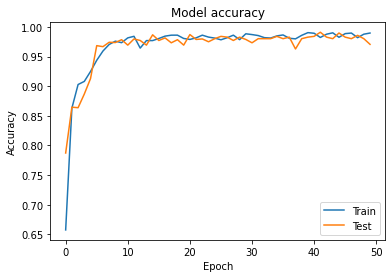

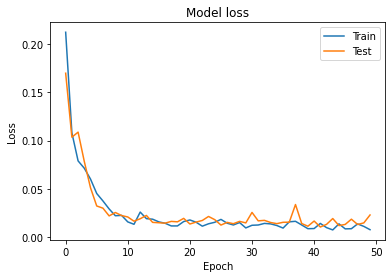

In [136]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
def pred_real(model, te_x, te_y, ref):
  '''
  Predict data according to the ref
  '''
  speakers = ['jackson', 'nicolas', 'theo', 'yweweler']
  n = te_y.shape[0]
  nb_ref = ref.shape[0]
  true = 0
  miss = 0
  for i in range(n):
    prob = np.zeros(nb_ref)
    for j in range(nb_ref):
      ## pred for te_x[i] and ref[j]
      prob[j] = model.predict([[te_x[i],], [ref[j],]])
    label_pred = np.argmin(prob) ## pos of the min proba
    if label_pred != te_y[i]:
      miss += 1
      print("MISS: pred {} ('{}') \t expected {} ('{}')" \
            .format(int(label_pred), \
                    speakers[int(label_pred)], \
                    int(te_y[i]), \
                    speakers[int(te_y[i])]))
    else:
      true += 1
    
  return true / n, miss

In [164]:
print(X_test.shape)
print(y_test.shape)
print(ref.shape)

(400, 1, 50)
(400,)
(4, 1, 50)


In [165]:
## we use X_test and y_test
acc, nb_miss = pred_real(model, X_test, y_test, ref)

MISS: pred 1 ('nicolas') 	 expected 2 ('theo')
MISS: pred 2 ('theo') 	 expected 3 ('yweweler')
MISS: pred 1 ('nicolas') 	 expected 2 ('theo')
MISS: pred 1 ('nicolas') 	 expected 3 ('yweweler')
MISS: pred 2 ('theo') 	 expected 3 ('yweweler')
MISS: pred 2 ('theo') 	 expected 3 ('yweweler')
MISS: pred 2 ('theo') 	 expected 3 ('yweweler')


In [166]:
print(acc)
print(nb_miss)

0.9825
7
